In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import scipy.stats
from scipy.spatial import Voronoi, voronoi_plot_2d


import quantization as qtz
import function as fun

# Quantification d'une loi continue

Objectif : Minimiser la distorsion quadratique.

## 1. Algorithmes pour la quantification scalaire. (dim=1)

On définit ci-dessous la fonction plusproche qui va calculer l'indice du centroïde le plus proche d'un point $X_{i}$ de notre échantillon $X_{cible}$.

Cette fonction nous sera très utile car elle permet de calculer l'indice du centre le plus proche d'un point en fonction d'une liste de centres que l'on peut actualiser au fur et à mesure.

Le principe est le suivant:

* Initialisation: on initialise la distance minimale courante au float le plus large et l'indice à -1. Si on le retrouve en sortie d'algorithme on pourra voir s'il y a un problème.

* Boucle sur la liste des centroïde: 
    1. On calcule la distance au centre de la cellule $C_{i}$ 
    2. On regarde si elle est plus petite que la distance minimale courante
    3. On associe l'indice à l'indice courant de la boucle si la condition est vérifiée.



Voir le Code dans function.py

Remarques: 


* On choisit ici de calculer les distances avec $ | X_{i} - C_{i} |^{2} \ $ en dimension 1 plutôt qu'avec la fonction np.linalg.norm car celle-ci rallonge considérablement les calculs.
* On rappelle que l'on cherche à minimiser la distorsion quadratique, en passant à l'échantillon cela revient à calculer les distances au carré.
* Dans le cadre multidimensionnel, il faudra utiliser np.linalg.norm.


### 1.1 Algorithme de Kmeans (dim=1)

On définit la fonction kmeans_Lloyd.
Le principe de cette fonction est simple:


1. On parcourt la liste des points $X_{cible}$ et on recherche pour chaque point son centroïde le plus proche et son indice.
2. On actualise les variables courantes Assignation_cour, compteur_cour, dist_total_it.
3. On actualise les centres à l'aide des variables courantes.
4. On récupère la distorsion à l'itération it.
5. On passe à l'itération suivante



Les rôles de ces variables courantes sont les suivantes:
* Assignation_cour: somme les points les plus proches des centres associées au numéro $indice$ récupérées par plusproche
* compteur_cour: compte le nombre de points associée au centroïde numéro $indice$
 * dist_cour_it: somme les distances entre les points et leurs centroïdes le plus proche à l'itération it



Remarques:
1. On se passe de mettre lst_centre en paramètre de la fonction car on les initialise en les choisissant parmi la liste X, ou bien, comme on connait la densité on peut directement les choisir suivant la densité.
2. L'étape la plus longue de cet algorithme, comme dit dans le pdf, est le calcul de plusproche. C'est pourquoi, pour avoir des temps de calculs raisonnables avec des grands échantillons X, il faut optimiser cette fonction.  
  


#### 1.1.1 La loi uniforme sur $[0,1]$

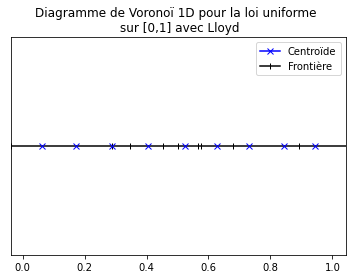

In [2]:
n=1000
N=9
X_cible=npr.rand(n)
lst_centre_u_1d=npr.rand(N)
lst_centre_u_1d, lst_proba_u_1d, dist_tab_u_1d=qtz.kmeans_Lloyd(X=X_cible,centers_init=lst_centre_u_1d,N=N,kmax=300)
plt.title("Diagramme de Voronoï 1D pour la loi uniforme \n sur [0,1] avec Lloyd")
fun.affiche_voro_1D(lst_centre_u_1d)

In [3]:
print(lst_proba_u_1d)

[0.107 0.105 0.115 0.123 0.109 0.106 0.089 0.117 0.129]


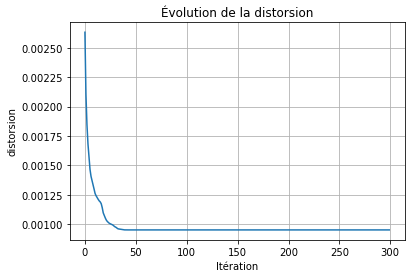

In [4]:
plt.xlabel("Itération")
plt.ylabel("distorsion")
plt.title("Évolution de la distorsion")
plt.plot(dist_tab_u_1d)
plt.grid()
plt.show()

#### 1.1.2 La loi normal centrée réduite

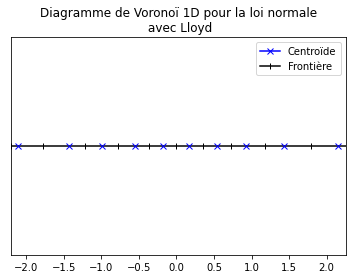

In [5]:
n=1000
N=10
X_cible=npr.normal(0,1,n)
lst_centre_n_1d=np.sort(npr.normal(0,1,N))
lst_centre_n_1d, lst_proba_n_1d, dist_tab_n_1d=qtz.kmeans_Lloyd(X=X_cible,centers_init=lst_centre_n_1d,N=N,kmax=300)

plt.title("Diagramme de Voronoï 1D pour la loi normale\n avec Lloyd")
fun.affiche_voro_1D(lst_centre_n_1d)

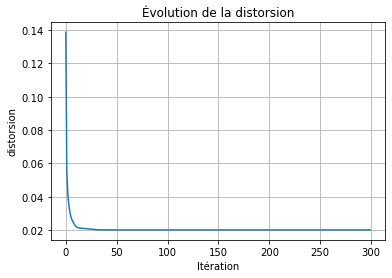

In [6]:
plt.xlabel("Itération")
plt.ylabel("distorsion")
plt.title("Évolution de la distorsion")
plt.grid()
plt.plot(dist_tab_n_1d)
plt.show()

Quelques remarques:

1. On a choisit 1000 points et 300 itérations et on a déjà une dizaine de secondes de calculs (selon la puissance de la machine). On peut voir que si l'on augmente la taille de l'échantillon, on peut avoir des temps de calculs très long. ( voir la suite )
2. On peut voir que la distorsion ne plus décroit quasiment plus à partir de la vingtième itération.


In [7]:
print("Différence entre la distorsion[20] et distorsion[200] de la loi centrée réduite: \n",dist_tab_n_1d[20]-dist_tab_n_1d[200],"\n \n")
print("Différence entre la distorsion[20] et distorsion[200] de la loi uniforme sur [0,1]: \n ",dist_tab_u_1d[20]-dist_tab_u_1d[200])


Différence entre la distorsion[20] et distorsion[200] de la loi centrée réduite: 
 0.0007333287276707588 
 

Différence entre la distorsion[20] et distorsion[200] de la loi uniforme sur [0,1]: 
  0.0001019478908569813


3. Cependant, comme illustré ci-dessus il est difficile d'introduire un critère d'arrêt car la fin de la forte décroissance de la distorsion dépend de l'échantillon que l'on étudie.

### 1.2 Algorithme du gradient déterministe

#### 1.2.1 La loi normale centrée réduite

Concentrons nous sur le cas de la loi normale.

Tout d'abord, il faut calculer la direction de descente donnée par la fonction grad_list. (voir le pdf pour la formule explicite)




La méthode de gradient déterministe est donnée par la fonction method_Grad_normal.

Le principe est le suivant:

* On actualise les centres avec la formule suivante: lst_centre=lst_centre-gamma*grad_list(lst_centre)
* On calcule la distorsion et on la stocke à l'aide des mêmes variables courantes que pour kmeans en dimension 1 (sauf Assignation_cour car nous n'en avons pas besoin).
* On passe à la itération suivante

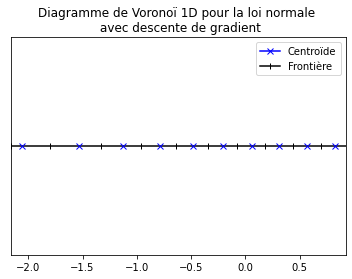

In [8]:
n=1000
N=10
X_cible=npr.normal(0,1,n)
lst_centre_grad=np.sort(npr.normal(0,1,N))
lst_centre_grad, lst_proba_grad, dist_tab_grad=qtz.method_Grad_normal(X=X_cible,centers_init=lst_centre_grad,N=N,gammainit=0.73,kmax=300)
plt.title("Diagramme de Voronoï 1D pour la loi normale \n avec descente de gradient")
fun.affiche_voro_1D(lst_centre_grad)

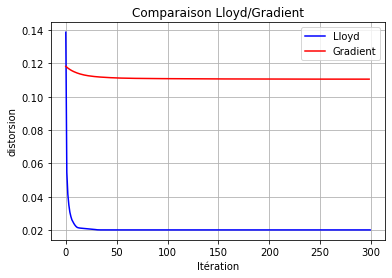

In [9]:

plt.xlabel("Itération")
plt.ylabel("distorsion")
plt.title("Comparaison Lloyd/Gradient")
plt.grid()
plt.plot(dist_tab_n_1d,color="blue",label="Lloyd")
plt.plot(dist_tab_grad,color="red",label="Gradient")
plt.legend()
plt.show()

Remarques:
1. On a sensiblement le même temps de calcul car on utilise autant de fois la fonction plusproche.
2. Le défi de cet algorithme est de trouver le pas le plus adapté pour minimiser la distorsion le plus rapidement possible.

In [10]:
x=np.linspace(0,1,20)
centre_init=np.sort(npr.normal(0,1,N))
min_tab=[]
for gamma_i in x:
    lst_centre_grad, lst_proba_grad, dist_tab_grad=qtz.method_Grad_normal(X_cible,centers_init=centre_init,N=N,gammainit=gamma_i,kmax=300)
    min_tab.append(dist_tab_grad[-1])


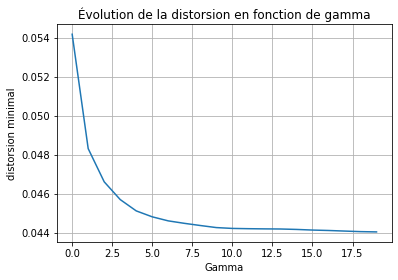

In [11]:
plt.xlabel("Gamma")
plt.ylabel("distorsion minimal")
plt.title("Évolution de la distorsion en fonction de gamma")
plt.grid()
plt.plot(min_tab)
plt.show()

In [12]:
print(x[np.argmin(min_tab)])

1.0


## 2. Algorithmes pour la quantification vectorielle

### 2.1 Algorthimes de kmeans


In [13]:
n=1000
N=20
X_cible=npr.normal(0,1,size=[n,2])
lst_centre_n_2d=npr.normal(0,1,size=[N,2])
lst_centre_n_2d, lst_proba_n_2d, dist_tab_n_2d=qtz.kmeans_Lloyd_d(X=X_cible,centers_init=lst_centre_n_2d,n=n,N=N,kmax=1500)

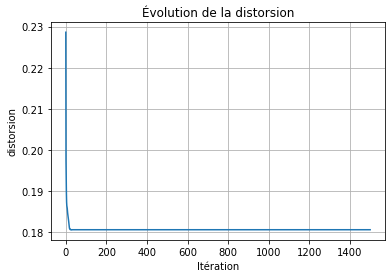

0.18052612189391737


In [14]:
plt.xlabel("Itération")
plt.ylabel("distorsion")
plt.title("Évolution de la distorsion")
plt.plot(dist_tab_n_2d)
plt.grid()
plt.show()
print(min(dist_tab_n_2d))

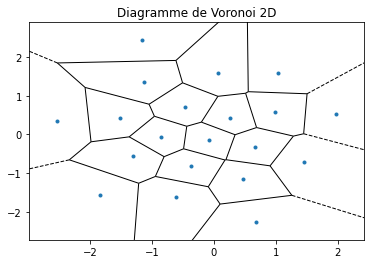

In [15]:
vor=Voronoi(lst_centre_n_2d)
fig = voronoi_plot_2d(vor,show_vertices=False)
plt.title("Diagramme de Voronoi 2D")
plt.show()

### 2.2 Competitive Learning Vector Quantization (CLVQ)

Le choix du pas est crucial dans notre problème pour s'assurer que l'algorithme converge en un nombre raisonnable d'itérations. Nous décidons de le définir suivant l'expression de 3.2.2 de Optimal quadratic quantization for numerics: the Gaussian
case.Gilles PAGES,Jacques PRINTEMS

Principe de l'algorithme:

Tant que it < kmax faire:

* On recherche le centroïde le plus proche d'un point $X_{cible}$ à l'aide de la fonction plusproche_d
* On actualise $\gamma_n$ qui est le pas en fonction de l'itération it et de N (nombre de centres)
* On actualise le centre le plus proche selon la formule (voir le pdf, 2.2 Algorithme pour la quantification verctorielle)
* On passe au point suivant de $X_{cible}$

it prend la valeur it+1




Bien évidemment comme pour les autres algorithmes, on récupère la distorsion à l'itération it, et les probabilités à la toute fin à l'aide de compteur_cour.

In [16]:
n=1000
N=20
X_cible=npr.normal(0,1,size=[n,2])
lst_centre_clvq=npr.normal(0,1,size=[N,2])
lst_centre_clvq, lst_proba_clvq, dist_tab_clvq=qtz.CLVQ_normal(X=X_cible,centers_init=lst_centre_clvq,n=n,N=N,kmax=1500,gamma_init=0.1)

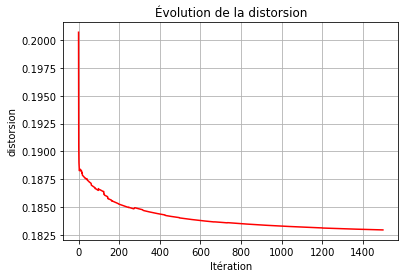

0.1829594241182498


In [17]:

plt.plot(dist_tab_clvq,color="red")
plt.xlabel("Itération")
plt.ylabel("distorsion")
plt.title("Évolution de la distorsion")

plt.grid()
plt.show()
print(min(dist_tab_clvq))

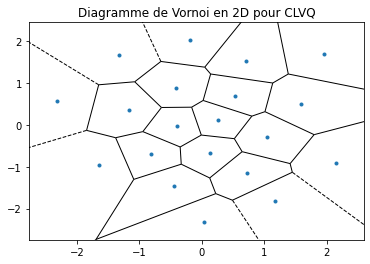

In [18]:
vor2=Voronoi(lst_centre_clvq)
fig = voronoi_plot_2d(vor2,show_vertices=False)
plt.title("Diagramme de Vornoi en 2D pour CLVQ")
plt.show()

Nous pouvons voir que globalement, nous avons le même ordre de grandeur pour la distorsion pour les 2 algorithmes CLVQ et Kmeans. Cependant, on peut voir que la décroissance de la distorsion de CLVQ continue tandis que celle de Kmean ne bouge plus.

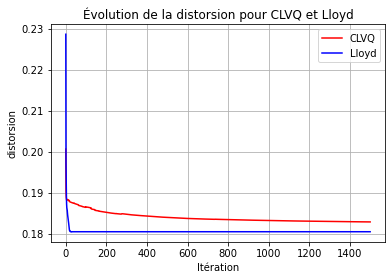

In [19]:

plt.plot(dist_tab_clvq,color="red",label="CLVQ")
plt.plot(dist_tab_n_2d,color="blue",label="Lloyd")
plt.legend()
plt.grid()
plt.xlabel("Itération")
plt.ylabel("distorsion")
plt.title("Évolution de la distorsion pour CLVQ et Lloyd")
plt.show()

De plus, CLVQ peut être encore amélioré en ajustant le paramètre $\gamma_n$. Voyons avec plus de points et de centres.

In [20]:
n=1000
N=20
X_cible=npr.normal(0,1,size=[n,2])
centre_init=npr.normal(0,1,size=[N,2])
lst_centre_clvq2, lst_proba_clvq2, dist_tab_clvq2=qtz.CLVQ_normal(X=X_cible,centers_init=centre_init,n=n,N=N,kmax=1500,gamma_init=0.01)
lst_centre_n_2d2, lst_proba_n_2d2, dist_tab_n_2d2=qtz.kmeans_Lloyd_d(X=X_cible,centers_init=centre_init,n=n,N=N,kmax=1500)

n= 1000  , N= 20 et kmax= 1500


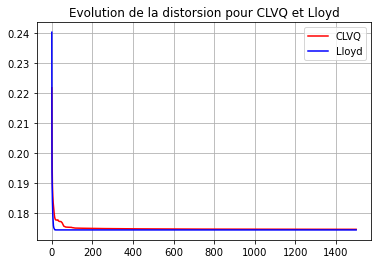

In [21]:
print("n=",n," , N=",N,"et kmax=",1500)
plt.plot(dist_tab_clvq2,color="red",label="CLVQ")
plt.plot(dist_tab_n_2d2,color="blue",label="Lloyd")
plt.title("Evolution de la distorsion pour CLVQ et Lloyd")
plt.legend()
plt.grid()
plt.show()